# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

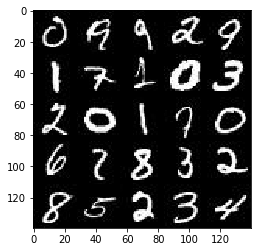

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

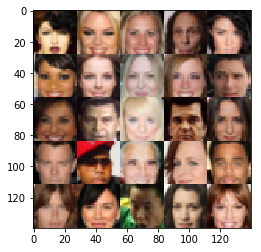

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), "inputs_z")
    learning_rate = tf.placeholder(tf.float32, name="lr")
    
    return inputs_real, inputs_z, learning_rate

#warning on tensorflow 1.2 and above
#https://github.com/tensorflow/tensorflow/issues/11315
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
#if we use leaky relu and dropout, we add in fact two more hyperparameters
alpha = 0.01
keep_prob = 0.9

leaky_relu = lambda x: tf.maximum(alpha * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    def input_conv_layer(inputs, filters):
        x = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        x = leaky_relu(x)
        return x

    def deep_conv_layer(inputs, filters):
        x = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        x = tf.layers.batch_normalization(x, training=True)
        x = leaky_relu(x)
        x = tf.nn.dropout(x, keep_prob=keep_prob)
        return x


    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = input_conv_layer(images, 64)
        x2 = deep_conv_layer(x1, 128)
        x3 = deep_conv_layer(x2, 256)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:


def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    def input_layer(inputs, dim, is_train=True):
        x = tf.layers.dense(inputs, 7*7*dim)
        x = tf.reshape(x, (-1, 7, 7, dim))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leaky_relu(x)
        return x

    def deep_conv_layer(inputs, filters, is_train=True):
        x = tf.layers.conv2d_transpose(inputs, filters, 5, 2, 'same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leaky_relu(x)
        x = tf.nn.dropout(x, keep_prob=keep_prob)
        return x

    with tf.variable_scope('generator', reuse = not is_train):
        x1 = input_layer(z, 512, is_train)
        x2 = deep_conv_layer(x1, 256, is_train)
        x3 = deep_conv_layer(x2, 128, is_train)
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, 1, 'same')   
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
#YAHP - yet another hyperparameter :)
smooth = 0.1

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_real,
            labels = tf.ones_like(d_model_real) * (1-smooth)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake,
            labels = tf.zeros_like(d_model_fake)
        )
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake,
            labels = tf.ones_like(d_model_fake)
        )
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    trainable_v = tf.trainable_variables()
    discriminator_v = [var for var in trainable_v if var.name.startswith('discriminator')]
    generator_v = [var for var in trainable_v if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        discriminator_train_opt = tf.train.AdamOptimizer(
            learning_rate = learning_rate,
            beta1 = beta1
        ).minimize(
            d_loss, 
            var_list = discriminator_v
        )
        
        generator_train_opt = tf.train.AdamOptimizer(
            learning_rate = learning_rate,
            beta1 = beta1
        ).minimize(
            g_loss,
            var_list = generator_v
        )    
    
    return discriminator_train_opt, generator_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
import time

#more model parameters
print_every = 10
show_every = 100
images_to_show = 16
losses = []

def train(epoch_count, batch_size, z_dim, learning_rate, 
                 beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    
    real_input_t, z_input_t, learning_rate_t = model_inputs(
        image_width,
        image_height,
        image_channels,
        z_dim
    )
    
    d_loss, g_loss = model_loss(real_input_t, z_input_t, image_channels)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_t, beta1)
        
    #init trainer    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            start = time.time()
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    d_opt,
                    feed_dict={
                        real_input_t:batch_images,
                        z_input_t: batch_z,
                        learning_rate_t: learning_rate
                    }
                )
                
                _ = sess.run(
                    g_opt,
                    feed_dict={
                        real_input_t:batch_images,
                        z_input_t: batch_z,
                        learning_rate_t: learning_rate
                    }
                )
                
                #show_generator_output(sess, images_to_show, z_input_t,
                #                          image_channels, data_image_mode)
                
                if steps % print_every == 0:
                    end = time.time()
                    train_loss_d = d_loss.eval({z_input_t: batch_z, 
                                                real_input_t:batch_images})
                    train_loss_g = g_loss.eval({z_input_t: batch_z})
                    
                    print("Epoch {}/{}".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          '{:.4f} sec/every {} batches'.format((end-start), print_every)
                         )
                    losses.append((train_loss_d, train_loss_g))
                    start = time.time()
                    
                if steps % show_every == 0:
                    show_generator_output(sess, images_to_show, z_input_t,
                                          image_channels, data_image_mode)
                    
        #show last model
        print("Most recent model:")
        show_generator_output(sess, images_to_show, z_input_t,
                                          image_channels, data_image_mode) 
        saver.save(sess, './generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator Loss: 1.9126... Generator Loss: 1.9484 4.8730 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.3515... Generator Loss: 6.6866 4.5622 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.3469... Generator Loss: 5.8321 4.5612 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.3413... Generator Loss: 5.7605 4.5599 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.3386... Generator Loss: 6.1347 4.5690 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.3617... Generator Loss: 7.3825 4.5661 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.5156... Generator Loss: 1.0571 4.5636 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.8076... Generator Loss: 1.9206 4.5628 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.5104... Generator Loss: 2.5123 4.5742 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.4368... Generator Loss: 3.1415 4.5646 sec/every 10 batches


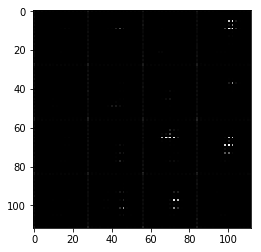

Epoch 1/2 Discriminator Loss: 0.3567... Generator Loss: 4.9693 5.0566 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1672... Generator Loss: 1.1601 4.5612 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.8177... Generator Loss: 1.5580 4.5576 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.7193... Generator Loss: 1.6753 4.5538 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2648... Generator Loss: 0.8044 4.5552 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.0318... Generator Loss: 1.4755 4.5595 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 3.5318... Generator Loss: 6.1027 4.5588 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1433... Generator Loss: 0.7399 4.5576 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.7239... Generator Loss: 2.5450 4.5615 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.9780... Generator Loss: 2.4740 4.5550 sec/every 10 batches


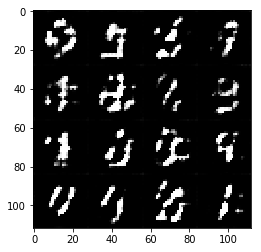

Epoch 1/2 Discriminator Loss: 0.8050... Generator Loss: 1.6020 5.0434 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.0278... Generator Loss: 1.5527 4.5552 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.7826... Generator Loss: 1.4150 4.5598 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.4934... Generator Loss: 0.5107 4.5601 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.8379... Generator Loss: 1.1907 4.5586 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.7234... Generator Loss: 1.3647 4.5664 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.8274... Generator Loss: 1.8768 4.5657 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 2.8286... Generator Loss: 0.1157 4.5651 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1642... Generator Loss: 0.9572 4.5607 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2905... Generator Loss: 1.4990 4.5710 sec/every 10 batches


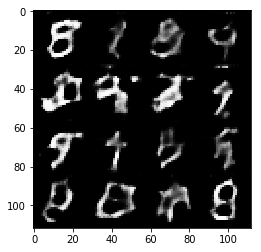

Epoch 1/2 Discriminator Loss: 1.2612... Generator Loss: 1.5050 5.0970 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.3067... Generator Loss: 0.7874 4.5696 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.0379... Generator Loss: 1.1064 4.5683 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2623... Generator Loss: 0.7282 4.5712 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.0992... Generator Loss: 2.0174 4.5689 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1938... Generator Loss: 0.7729 4.5685 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.9895... Generator Loss: 1.1658 4.5700 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2663... Generator Loss: 2.3683 4.5636 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1438... Generator Loss: 1.2843 4.5631 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1521... Generator Loss: 1.1288 4.5568 sec/every 10 batches


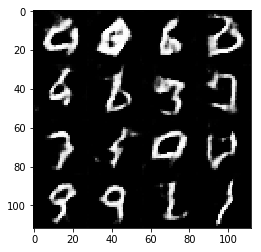

Epoch 1/2 Discriminator Loss: 1.4229... Generator Loss: 0.5548 5.2550 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1204... Generator Loss: 0.9937 4.5529 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1334... Generator Loss: 0.8429 4.5543 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.7262... Generator Loss: 0.3408 4.5510 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1725... Generator Loss: 0.9651 4.5592 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1835... Generator Loss: 1.2753 4.5681 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2527... Generator Loss: 2.0045 4.5965 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.8236... Generator Loss: 0.3302 4.5671 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.3406... Generator Loss: 0.5352 4.5695 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1787... Generator Loss: 0.8293 4.5625 sec/every 10 batches


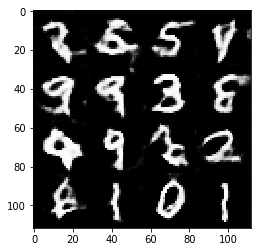

Epoch 1/2 Discriminator Loss: 1.4295... Generator Loss: 0.5848 5.0735 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.0351... Generator Loss: 1.8122 4.5666 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.3469... Generator Loss: 2.5842 4.5690 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.0584... Generator Loss: 0.9961 4.5605 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1378... Generator Loss: 1.6074 4.5584 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2681... Generator Loss: 1.4766 4.5529 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1743... Generator Loss: 1.7566 4.5666 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2369... Generator Loss: 1.5426 4.5787 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1993... Generator Loss: 0.8856 4.5606 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.6527... Generator Loss: 0.4495 4.5583 sec/every 10 batches


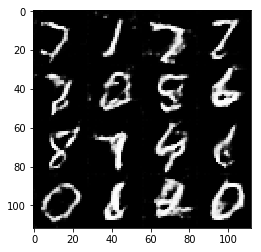

Epoch 1/2 Discriminator Loss: 1.2698... Generator Loss: 1.8168 5.0838 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.0725... Generator Loss: 0.9222 4.5645 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1891... Generator Loss: 1.6745 4.5664 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.5001... Generator Loss: 2.3529 4.5701 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.8738... Generator Loss: 0.3090 4.5709 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1106... Generator Loss: 0.8440 4.5644 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1015... Generator Loss: 0.9748 4.5619 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2545... Generator Loss: 0.6229 4.5706 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1507... Generator Loss: 1.3303 4.5567 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.5101... Generator Loss: 0.5101 4.5583 sec/every 10 batches


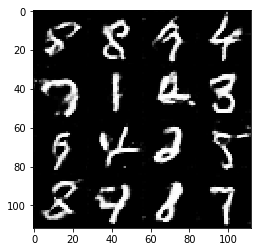

Epoch 1/2 Discriminator Loss: 1.1396... Generator Loss: 0.7615 5.0685 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.0365... Generator Loss: 1.4275 4.5678 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.3740... Generator Loss: 0.7698 4.5655 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2052... Generator Loss: 1.4554 4.5639 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2893... Generator Loss: 0.6894 4.5589 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.9492... Generator Loss: 1.3800 4.5678 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1023... Generator Loss: 0.8183 4.5674 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.9218... Generator Loss: 0.2897 4.5762 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2980... Generator Loss: 0.7730 4.5758 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2297... Generator Loss: 0.7224 4.5706 sec/every 10 batches


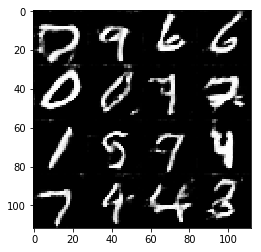

Epoch 1/2 Discriminator Loss: 1.1949... Generator Loss: 1.3848 5.1391 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1540... Generator Loss: 0.9225 4.5745 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2730... Generator Loss: 0.6421 4.5991 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1879... Generator Loss: 0.8732 4.5746 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.6547... Generator Loss: 0.4595 4.5599 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.3296... Generator Loss: 0.6837 4.5627 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.0895... Generator Loss: 1.2118 4.5597 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.2402... Generator Loss: 0.8080 4.5639 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1117... Generator Loss: 1.1453 4.5613 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1499... Generator Loss: 2.0713 4.5674 sec/every 10 batches


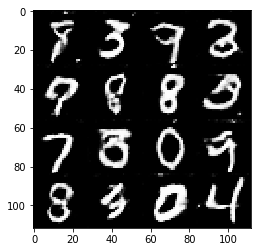

Epoch 1/2 Discriminator Loss: 1.3474... Generator Loss: 0.5032 5.0998 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 0.9721... Generator Loss: 0.9141 4.5707 sec/every 10 batches
Epoch 1/2 Discriminator Loss: 1.1809... Generator Loss: 1.1161 4.5628 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1987... Generator Loss: 0.8594 4.5625 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2231... Generator Loss: 0.9533 4.5646 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.3636... Generator Loss: 0.6246 4.5603 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.3624... Generator Loss: 0.6276 4.5705 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2513... Generator Loss: 0.7122 4.5652 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2878... Generator Loss: 0.9220 4.5570 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1398... Generator Loss: 1.0380 4.5448 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.9673... Generator Loss: 0.2650 4.5578 sec/every 10 batches

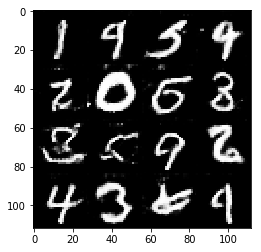

Epoch 2/2 Discriminator Loss: 1.2221... Generator Loss: 1.0286 5.0668 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2190... Generator Loss: 0.7135 4.5572 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.7878... Generator Loss: 2.7548 4.5587 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1929... Generator Loss: 0.8050 4.5602 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1137... Generator Loss: 0.8581 4.5515 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1351... Generator Loss: 1.4771 4.5613 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1090... Generator Loss: 1.0851 4.5612 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1199... Generator Loss: 1.2768 4.5535 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0765... Generator Loss: 0.9123 4.5568 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.3932... Generator Loss: 1.4305 4.5545 sec/every 10 batches


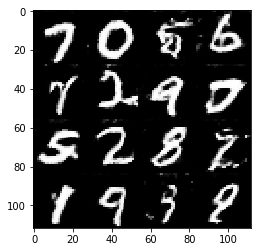

Epoch 2/2 Discriminator Loss: 1.3531... Generator Loss: 0.5930 5.0653 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.3792... Generator Loss: 2.0734 4.5444 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2451... Generator Loss: 0.7063 4.5608 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1711... Generator Loss: 1.5434 4.5431 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2330... Generator Loss: 0.8029 4.5445 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1656... Generator Loss: 0.8239 4.5421 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1584... Generator Loss: 0.9035 4.5473 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.5928... Generator Loss: 0.5002 4.5691 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0932... Generator Loss: 1.0430 4.5658 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1071... Generator Loss: 1.0551 4.5597 sec/every 10 batches


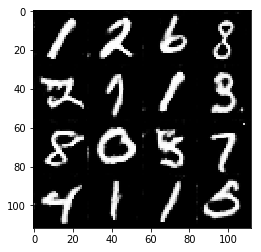

Epoch 2/2 Discriminator Loss: 1.1553... Generator Loss: 0.8671 5.0735 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1307... Generator Loss: 1.0097 4.5575 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.3195... Generator Loss: 0.6175 4.5548 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.5233... Generator Loss: 0.5617 4.5432 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2344... Generator Loss: 1.0687 4.5493 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2545... Generator Loss: 1.0762 4.5629 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.3433... Generator Loss: 0.6452 4.5576 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0703... Generator Loss: 1.7036 4.5591 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0070... Generator Loss: 1.0909 4.5599 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.5583... Generator Loss: 2.1874 4.5575 sec/every 10 batches


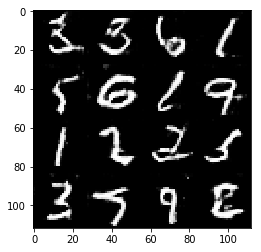

Epoch 2/2 Discriminator Loss: 1.2830... Generator Loss: 0.8681 5.0790 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2079... Generator Loss: 1.1249 4.5570 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0599... Generator Loss: 1.2233 4.5595 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2197... Generator Loss: 0.8639 4.5503 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.4754... Generator Loss: 1.8640 4.5507 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0712... Generator Loss: 1.1940 4.5516 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1794... Generator Loss: 0.9515 4.5465 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2737... Generator Loss: 0.6981 4.5499 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1091... Generator Loss: 1.0430 4.5521 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2009... Generator Loss: 0.9023 4.5443 sec/every 10 batches


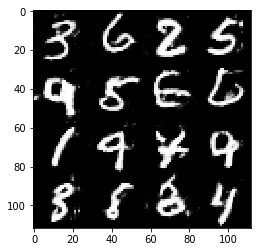

Epoch 2/2 Discriminator Loss: 1.1589... Generator Loss: 1.0606 5.0638 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0609... Generator Loss: 1.2934 4.5432 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1850... Generator Loss: 1.5228 4.5496 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.3711... Generator Loss: 2.1725 4.5476 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1144... Generator Loss: 0.7431 4.5475 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2777... Generator Loss: 1.7398 4.5446 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0615... Generator Loss: 1.6681 4.5451 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0252... Generator Loss: 1.0658 4.5489 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.5799... Generator Loss: 0.4262 4.5438 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1636... Generator Loss: 0.8083 4.5452 sec/every 10 batches


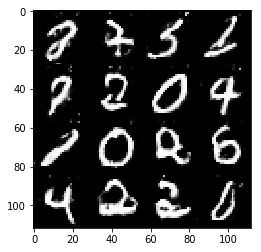

Epoch 2/2 Discriminator Loss: 1.1952... Generator Loss: 0.7435 5.0989 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2506... Generator Loss: 0.7317 4.5441 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1596... Generator Loss: 0.9456 4.5437 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1984... Generator Loss: 0.8638 4.5539 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.7321... Generator Loss: 0.3756 4.5502 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2331... Generator Loss: 0.8179 4.5439 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0692... Generator Loss: 1.2354 4.5444 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2247... Generator Loss: 0.7948 4.5472 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2200... Generator Loss: 0.8178 4.5430 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0495... Generator Loss: 1.3310 4.5480 sec/every 10 batches


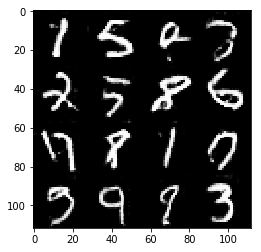

Epoch 2/2 Discriminator Loss: 1.0398... Generator Loss: 1.1364 5.3706 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1361... Generator Loss: 1.2111 4.5788 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1795... Generator Loss: 1.2353 4.5561 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2298... Generator Loss: 0.7706 4.5477 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1753... Generator Loss: 0.7482 4.5429 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0643... Generator Loss: 1.4942 4.5573 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0584... Generator Loss: 1.2902 4.5542 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1309... Generator Loss: 0.8819 4.5525 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1181... Generator Loss: 1.2307 4.5460 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0462... Generator Loss: 1.2369 4.5486 sec/every 10 batches


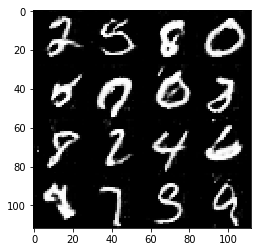

Epoch 2/2 Discriminator Loss: 1.0243... Generator Loss: 1.2504 5.1029 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2650... Generator Loss: 0.6878 4.5504 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0332... Generator Loss: 1.6143 4.5571 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1849... Generator Loss: 0.8054 4.5643 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.8451... Generator Loss: 0.3820 4.5561 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0649... Generator Loss: 1.4408 4.5618 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.3752... Generator Loss: 2.4605 4.5556 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.2573... Generator Loss: 0.7458 4.5586 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.3367... Generator Loss: 0.6879 4.5632 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.1235... Generator Loss: 0.9267 4.5620 sec/every 10 batches


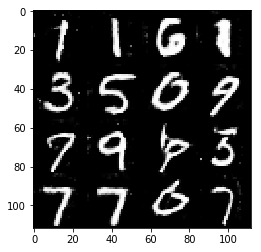

Epoch 2/2 Discriminator Loss: 1.3923... Generator Loss: 0.5570 5.1074 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0028... Generator Loss: 1.7086 4.5693 sec/every 10 batches
Epoch 2/2 Discriminator Loss: 1.0545... Generator Loss: 1.2095 4.5684 sec/every 10 batches
Most recent model:


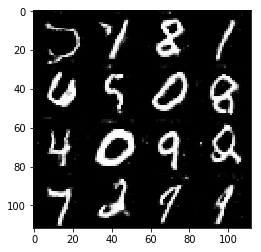

In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator Loss: 0.7308... Generator Loss: 1.4869 3.7266 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4903... Generator Loss: 2.5900 2.8807 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4911... Generator Loss: 2.4724 2.8755 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4212... Generator Loss: 3.2700 2.8686 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4358... Generator Loss: 2.9578 2.8671 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4706... Generator Loss: 2.7964 2.8677 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4464... Generator Loss: 2.6580 2.8729 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4827... Generator Loss: 2.5062 2.8714 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5679... Generator Loss: 2.0096 2.8768 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5324... Generator Loss: 2.3497 2.8786 sec/every 10 batches


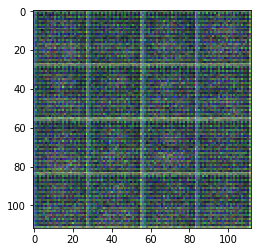

Epoch 1/1 Discriminator Loss: 0.5388... Generator Loss: 2.1958 3.3919 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.6246... Generator Loss: 3.3955 2.8786 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.6837... Generator Loss: 1.8448 2.8849 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4967... Generator Loss: 2.9968 2.8797 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4658... Generator Loss: 2.7251 2.8793 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4760... Generator Loss: 2.8892 2.8818 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4957... Generator Loss: 3.3616 2.8804 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4542... Generator Loss: 2.5363 2.8770 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4828... Generator Loss: 2.4569 2.8754 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4197... Generator Loss: 3.2810 2.8711 sec/every 10 batches


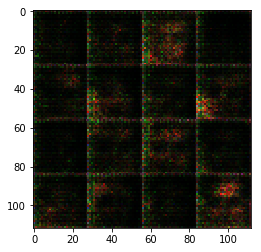

Epoch 1/1 Discriminator Loss: 0.5410... Generator Loss: 2.6877 3.6187 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4701... Generator Loss: 3.9314 2.8742 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4861... Generator Loss: 3.0539 2.8749 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4210... Generator Loss: 3.2052 2.8757 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.3912... Generator Loss: 3.8368 2.8913 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4069... Generator Loss: 4.1354 2.8904 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4124... Generator Loss: 4.3541 2.8931 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4515... Generator Loss: 4.5350 2.8842 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5073... Generator Loss: 5.1759 2.8854 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4644... Generator Loss: 2.4916 2.8808 sec/every 10 batches


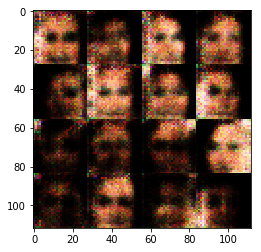

Epoch 1/1 Discriminator Loss: 0.4448... Generator Loss: 2.8529 3.3957 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4319... Generator Loss: 3.4483 2.8788 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0451... Generator Loss: 0.9336 2.8826 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5405... Generator Loss: 3.6545 2.8841 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4888... Generator Loss: 3.2396 2.8788 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4129... Generator Loss: 4.0885 2.8697 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4990... Generator Loss: 2.1714 2.8916 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5793... Generator Loss: 2.1577 2.9283 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4272... Generator Loss: 3.7535 2.9075 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4232... Generator Loss: 3.8564 2.8791 sec/every 10 batches


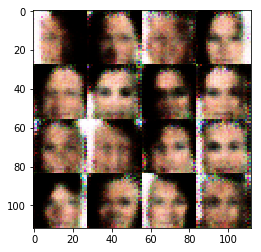

Epoch 1/1 Discriminator Loss: 0.4121... Generator Loss: 2.9608 3.3984 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4161... Generator Loss: 6.5701 2.8604 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.6398... Generator Loss: 1.6339 2.8675 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4771... Generator Loss: 2.6977 2.8655 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4348... Generator Loss: 3.1728 2.8690 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4831... Generator Loss: 2.7278 2.8694 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4282... Generator Loss: 3.5560 2.8664 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.6348... Generator Loss: 1.6464 2.8822 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4223... Generator Loss: 3.1868 2.8924 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4566... Generator Loss: 2.7005 2.8995 sec/every 10 batches


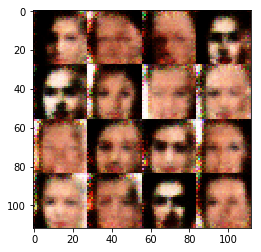

Epoch 1/1 Discriminator Loss: 0.4366... Generator Loss: 4.6137 3.4149 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0344... Generator Loss: 1.1669 2.8709 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8584... Generator Loss: 1.4624 2.8620 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4086... Generator Loss: 3.2871 2.8640 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4308... Generator Loss: 3.1330 2.8693 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5574... Generator Loss: 5.7419 2.8671 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.6049... Generator Loss: 2.2472 2.8691 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.3990... Generator Loss: 3.7510 2.8734 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5885... Generator Loss: 1.9577 2.8759 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5091... Generator Loss: 2.3951 2.8842 sec/every 10 batches


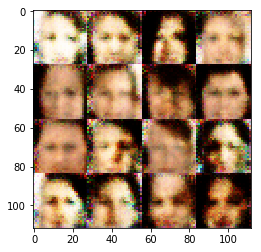

Epoch 1/1 Discriminator Loss: 0.5693... Generator Loss: 1.9601 3.4650 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4968... Generator Loss: 2.7301 2.8754 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.6239... Generator Loss: 1.6347 2.8851 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5412... Generator Loss: 2.2217 2.8757 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4180... Generator Loss: 3.6554 2.8724 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.6156... Generator Loss: 2.4480 2.8708 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.8100... Generator Loss: 0.3980 2.8786 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.6369... Generator Loss: 1.8809 2.8728 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4996... Generator Loss: 2.6472 2.8742 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4834... Generator Loss: 2.7836 2.8739 sec/every 10 batches


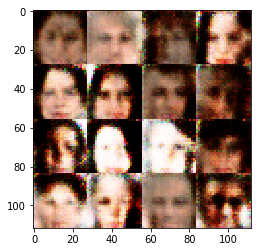

Epoch 1/1 Discriminator Loss: 0.5365... Generator Loss: 2.5550 3.4167 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5368... Generator Loss: 2.5069 2.8744 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7949... Generator Loss: 1.2711 2.8827 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5291... Generator Loss: 2.6344 2.8828 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5592... Generator Loss: 2.9581 2.8814 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5745... Generator Loss: 2.6362 2.8760 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5468... Generator Loss: 2.9780 2.8777 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.4721... Generator Loss: 4.2894 2.8813 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7775... Generator Loss: 1.4276 2.8744 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5589... Generator Loss: 2.5392 2.8749 sec/every 10 batches


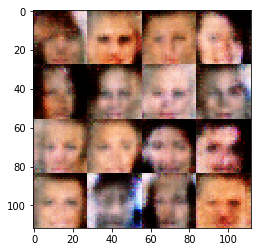

Epoch 1/1 Discriminator Loss: 1.9800... Generator Loss: 0.3890 3.3904 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5939... Generator Loss: 2.6280 2.8677 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8153... Generator Loss: 1.3529 2.8667 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7778... Generator Loss: 1.3410 2.8678 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7237... Generator Loss: 1.4911 2.8660 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7070... Generator Loss: 1.4667 2.8605 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.6473... Generator Loss: 2.9486 2.8676 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.6228... Generator Loss: 2.5203 2.8690 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7753... Generator Loss: 1.2180 2.8684 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7680... Generator Loss: 1.4688 2.8707 sec/every 10 batches


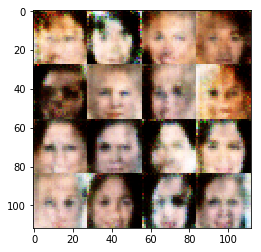

Epoch 1/1 Discriminator Loss: 0.7130... Generator Loss: 2.4511 3.3924 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5991... Generator Loss: 2.6637 2.8777 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5167... Generator Loss: 2.5428 2.8787 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.6615... Generator Loss: 0.4219 2.8776 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8999... Generator Loss: 1.1649 2.8804 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5528... Generator Loss: 2.4452 2.8796 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8237... Generator Loss: 4.0523 2.8628 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5727... Generator Loss: 2.1811 2.8641 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.6113... Generator Loss: 1.8649 2.8644 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.5113... Generator Loss: 2.3298 2.8829 sec/every 10 batches


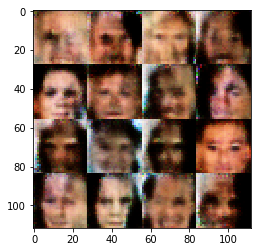

Epoch 1/1 Discriminator Loss: 0.5398... Generator Loss: 2.6649 3.4418 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8144... Generator Loss: 1.3530 2.8716 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9724... Generator Loss: 1.0732 2.8753 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9370... Generator Loss: 1.1219 2.8725 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7439... Generator Loss: 1.4974 2.8872 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7246... Generator Loss: 1.9434 2.8885 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.6571... Generator Loss: 2.5026 2.8863 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8195... Generator Loss: 1.3883 2.8800 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3351... Generator Loss: 0.7957 2.8756 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7755... Generator Loss: 2.1103 2.8850 sec/every 10 batches


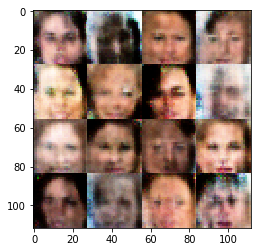

Epoch 1/1 Discriminator Loss: 0.7245... Generator Loss: 2.6060 3.4261 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9792... Generator Loss: 1.1835 2.8734 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8766... Generator Loss: 1.4630 2.8839 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9996... Generator Loss: 0.9358 2.9450 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4725... Generator Loss: 0.6413 2.9213 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8237... Generator Loss: 2.3551 2.8871 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8096... Generator Loss: 1.4065 2.8797 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8826... Generator Loss: 1.2268 2.8884 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9439... Generator Loss: 2.0464 2.8949 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8839... Generator Loss: 1.0928 2.8992 sec/every 10 batches


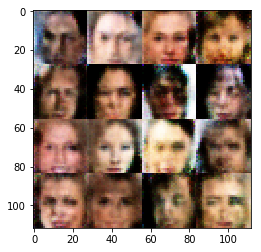

Epoch 1/1 Discriminator Loss: 1.2267... Generator Loss: 0.7064 3.4999 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7447... Generator Loss: 1.4511 2.8819 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8331... Generator Loss: 1.3158 2.8757 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8473... Generator Loss: 1.7297 2.8865 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7621... Generator Loss: 1.5264 2.8877 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2482... Generator Loss: 0.7060 2.8867 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0612... Generator Loss: 2.3013 2.8806 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7871... Generator Loss: 1.7488 2.8668 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8713... Generator Loss: 1.2629 2.8713 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8201... Generator Loss: 1.7640 2.8621 sec/every 10 batches


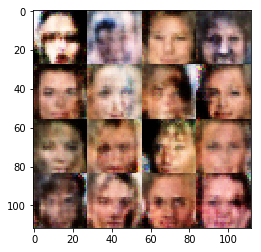

Epoch 1/1 Discriminator Loss: 0.8136... Generator Loss: 1.4235 3.4050 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0869... Generator Loss: 0.7503 2.8662 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9432... Generator Loss: 1.3107 2.8733 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0185... Generator Loss: 1.1353 2.8804 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0514... Generator Loss: 2.2979 2.8797 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0816... Generator Loss: 0.8302 2.8709 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8587... Generator Loss: 1.3294 2.8685 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9121... Generator Loss: 1.6594 2.8769 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9581... Generator Loss: 1.2209 2.8906 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7597... Generator Loss: 1.5567 2.8848 sec/every 10 batches


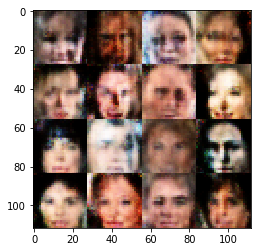

Epoch 1/1 Discriminator Loss: 1.1074... Generator Loss: 1.6952 3.7763 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0422... Generator Loss: 1.0493 2.9021 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0334... Generator Loss: 0.9945 2.9014 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0929... Generator Loss: 2.2668 2.8817 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9089... Generator Loss: 1.1067 2.8860 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9547... Generator Loss: 1.6957 2.8955 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0039... Generator Loss: 1.0199 2.8810 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8913... Generator Loss: 1.1693 2.8821 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1055... Generator Loss: 0.9794 2.8875 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8503... Generator Loss: 1.6532 2.9001 sec/every 10 batches


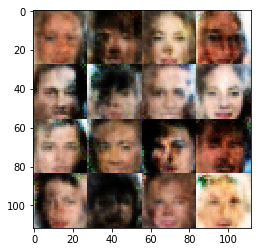

Epoch 1/1 Discriminator Loss: 0.8542... Generator Loss: 1.3169 3.4966 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8735... Generator Loss: 1.1923 2.8765 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.6155... Generator Loss: 0.4436 2.8636 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8382... Generator Loss: 1.4947 2.8644 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9279... Generator Loss: 1.8232 2.8678 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0686... Generator Loss: 1.1725 2.8744 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9311... Generator Loss: 1.2412 2.8845 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8004... Generator Loss: 2.0284 2.8841 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0393... Generator Loss: 1.1875 2.8980 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9960... Generator Loss: 1.2497 2.8806 sec/every 10 batches


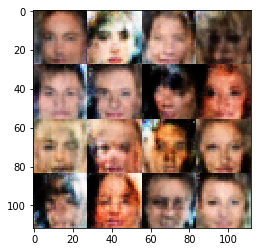

Epoch 1/1 Discriminator Loss: 1.2595... Generator Loss: 0.6580 3.4666 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2412... Generator Loss: 0.9051 2.8833 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0449... Generator Loss: 1.1311 2.8775 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9177... Generator Loss: 1.0488 2.8864 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9054... Generator Loss: 1.4292 2.8741 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8662... Generator Loss: 1.4005 2.8786 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7321... Generator Loss: 1.7854 2.8811 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7382... Generator Loss: 1.7742 2.8793 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9113... Generator Loss: 1.0741 2.8866 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0898... Generator Loss: 0.9011 2.8763 sec/every 10 batches


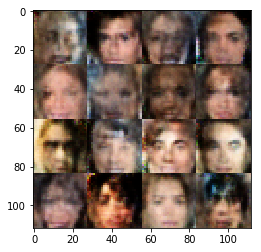

Epoch 1/1 Discriminator Loss: 1.1128... Generator Loss: 1.0417 3.4532 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3767... Generator Loss: 0.6746 2.8807 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1415... Generator Loss: 0.7943 2.8797 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1337... Generator Loss: 0.9304 2.8794 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8958... Generator Loss: 1.4842 2.8779 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1259... Generator Loss: 1.6489 2.8799 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9569... Generator Loss: 1.6308 2.8804 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0302... Generator Loss: 1.6015 2.8819 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8282... Generator Loss: 1.5115 2.8788 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9195... Generator Loss: 1.3294 2.8849 sec/every 10 batches


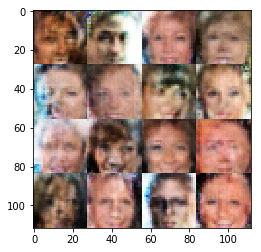

Epoch 1/1 Discriminator Loss: 1.0784... Generator Loss: 0.9988 3.4783 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1900... Generator Loss: 1.1553 2.8735 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0357... Generator Loss: 1.5197 2.8679 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0811... Generator Loss: 0.9286 2.8704 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9463... Generator Loss: 1.6283 2.8674 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0532... Generator Loss: 1.1486 2.8647 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9567... Generator Loss: 1.0323 2.8711 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8048... Generator Loss: 1.3005 2.8767 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9958... Generator Loss: 1.1855 2.8752 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2940... Generator Loss: 1.1033 2.8688 sec/every 10 batches


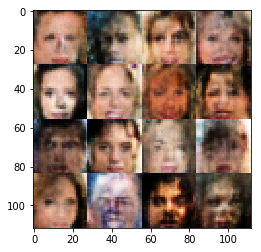

Epoch 1/1 Discriminator Loss: 1.3255... Generator Loss: 0.6840 3.4664 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1986... Generator Loss: 1.2981 2.8823 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9893... Generator Loss: 1.6608 2.8814 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2237... Generator Loss: 0.8718 2.8692 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0551... Generator Loss: 0.9980 2.8657 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8544... Generator Loss: 1.5061 2.8705 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1101... Generator Loss: 0.8340 2.8671 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4032... Generator Loss: 0.6164 2.8759 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0320... Generator Loss: 0.9395 2.8745 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9277... Generator Loss: 1.4717 2.8814 sec/every 10 batches


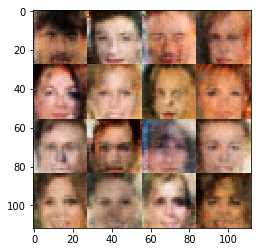

Epoch 1/1 Discriminator Loss: 0.9793... Generator Loss: 1.3614 3.4850 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1010... Generator Loss: 1.1654 2.8845 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.6246... Generator Loss: 1.8623 2.8807 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.6977... Generator Loss: 0.5729 2.8780 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9463... Generator Loss: 1.1608 2.8694 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3904... Generator Loss: 0.6212 2.8780 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0556... Generator Loss: 1.3023 2.8730 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0438... Generator Loss: 1.1027 2.8724 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1519... Generator Loss: 1.0420 2.8704 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1434... Generator Loss: 0.9046 2.8697 sec/every 10 batches


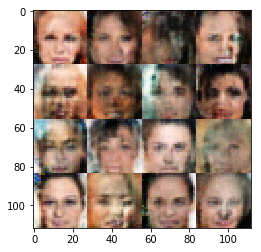

Epoch 1/1 Discriminator Loss: 0.9750... Generator Loss: 1.1584 3.4425 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9591... Generator Loss: 1.3709 2.8726 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8240... Generator Loss: 1.7969 2.8713 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0630... Generator Loss: 0.8839 2.8743 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2134... Generator Loss: 0.8036 2.8809 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3196... Generator Loss: 0.7503 2.8808 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2738... Generator Loss: 1.4118 2.8770 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2438... Generator Loss: 0.6559 2.8718 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1624... Generator Loss: 0.9391 2.8695 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9635... Generator Loss: 1.1333 2.8678 sec/every 10 batches


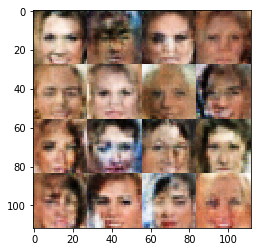

Epoch 1/1 Discriminator Loss: 1.6078... Generator Loss: 0.6808 3.4411 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1684... Generator Loss: 0.9689 2.8842 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2538... Generator Loss: 0.7943 2.9086 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2203... Generator Loss: 0.8996 2.8796 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1958... Generator Loss: 0.9371 2.8713 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.5154... Generator Loss: 0.6550 2.8664 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1233... Generator Loss: 1.0211 2.8681 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9432... Generator Loss: 1.3709 2.8761 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3256... Generator Loss: 0.7193 2.8815 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0444... Generator Loss: 1.2089 2.8785 sec/every 10 batches


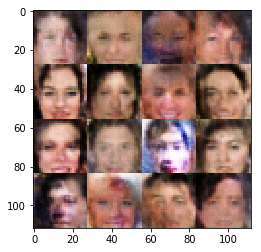

Epoch 1/1 Discriminator Loss: 1.2810... Generator Loss: 0.9947 3.5149 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2625... Generator Loss: 0.8193 2.8775 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2233... Generator Loss: 0.8289 2.8613 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1462... Generator Loss: 1.0243 2.8697 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1865... Generator Loss: 1.2033 2.8637 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9532... Generator Loss: 1.3460 2.8703 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.8711... Generator Loss: 0.6996 2.8823 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4312... Generator Loss: 0.7801 2.8763 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1665... Generator Loss: 0.8396 2.8797 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2069... Generator Loss: 0.8938 2.8795 sec/every 10 batches


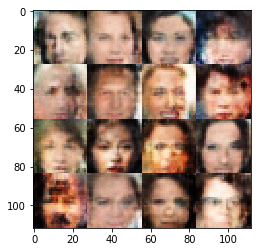

Epoch 1/1 Discriminator Loss: 1.1554... Generator Loss: 1.1604 3.4839 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1850... Generator Loss: 0.8663 2.8675 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9243... Generator Loss: 1.2273 2.8787 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3686... Generator Loss: 0.7221 2.8802 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8853... Generator Loss: 1.1435 2.8811 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0346... Generator Loss: 0.9847 2.8852 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3246... Generator Loss: 0.8717 2.8802 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2332... Generator Loss: 0.9638 2.8811 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0182... Generator Loss: 0.9510 2.8746 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8987... Generator Loss: 1.4470 2.8836 sec/every 10 batches


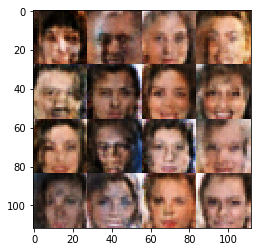

Epoch 1/1 Discriminator Loss: 1.1961... Generator Loss: 0.9047 3.5363 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0872... Generator Loss: 1.1513 2.8881 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1832... Generator Loss: 0.9242 2.8804 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1533... Generator Loss: 1.0910 2.8753 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2322... Generator Loss: 0.8833 2.8643 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3789... Generator Loss: 0.8903 2.8631 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0632... Generator Loss: 1.0665 2.8864 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2536... Generator Loss: 0.9429 2.8665 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0445... Generator Loss: 1.1674 2.8707 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2348... Generator Loss: 0.9144 2.8749 sec/every 10 batches


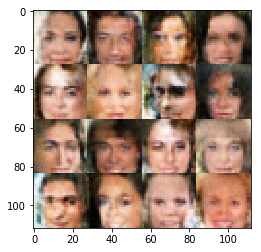

Epoch 1/1 Discriminator Loss: 1.2614... Generator Loss: 0.8644 3.4595 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3135... Generator Loss: 0.9282 2.8676 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2193... Generator Loss: 0.9723 2.8764 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0411... Generator Loss: 1.3235 2.8923 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2687... Generator Loss: 0.9642 2.8848 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2900... Generator Loss: 0.7597 2.8901 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0415... Generator Loss: 0.9992 2.8853 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2282... Generator Loss: 1.1370 2.8862 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2651... Generator Loss: 1.1795 2.8836 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0245... Generator Loss: 1.0929 2.8833 sec/every 10 batches


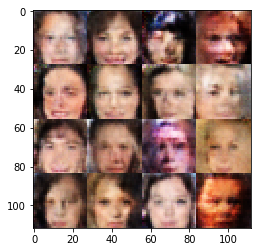

Epoch 1/1 Discriminator Loss: 1.2384... Generator Loss: 1.0003 3.5360 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1666... Generator Loss: 1.0458 2.8743 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1507... Generator Loss: 0.7863 2.8801 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1254... Generator Loss: 0.8973 2.8773 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2994... Generator Loss: 0.8236 2.8651 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0924... Generator Loss: 1.2186 2.8734 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2525... Generator Loss: 0.9069 2.8652 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2214... Generator Loss: 0.9838 2.8774 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1116... Generator Loss: 0.9065 2.8757 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0143... Generator Loss: 1.4689 2.8729 sec/every 10 batches


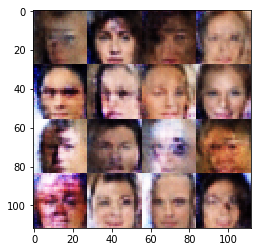

Epoch 1/1 Discriminator Loss: 1.4663... Generator Loss: 0.7115 3.7933 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2116... Generator Loss: 1.1596 2.8777 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3011... Generator Loss: 0.8061 2.8841 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9913... Generator Loss: 1.0798 2.8832 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3225... Generator Loss: 1.0590 2.8830 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2848... Generator Loss: 0.9337 2.8879 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9008... Generator Loss: 1.2127 2.8844 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0575... Generator Loss: 1.0228 2.8852 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9956... Generator Loss: 1.2040 2.8881 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9582... Generator Loss: 1.3021 2.8743 sec/every 10 batches


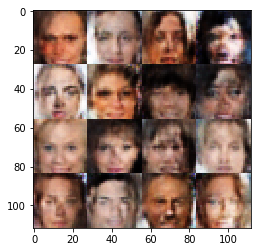

Epoch 1/1 Discriminator Loss: 1.2135... Generator Loss: 0.6271 3.5812 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2477... Generator Loss: 0.8293 2.8865 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9956... Generator Loss: 0.9738 2.8835 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.5493... Generator Loss: 0.5664 2.8948 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1009... Generator Loss: 1.1044 2.8848 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4099... Generator Loss: 0.6426 2.9089 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0413... Generator Loss: 1.1128 2.8776 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2364... Generator Loss: 0.8214 2.8860 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1530... Generator Loss: 0.9157 2.8868 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3285... Generator Loss: 0.8022 2.8803 sec/every 10 batches


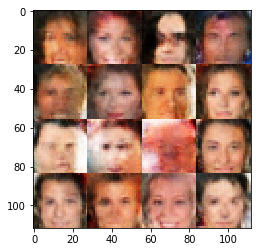

Epoch 1/1 Discriminator Loss: 0.9504... Generator Loss: 1.2708 3.4965 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2013... Generator Loss: 1.0306 2.8636 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2038... Generator Loss: 0.9624 2.8763 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2579... Generator Loss: 0.6946 2.8771 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0532... Generator Loss: 1.0354 2.8847 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3286... Generator Loss: 0.8411 2.8820 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1980... Generator Loss: 0.9903 2.8867 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3128... Generator Loss: 0.7742 2.8826 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9745... Generator Loss: 1.1950 2.8887 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1489... Generator Loss: 1.1612 2.8949 sec/every 10 batches


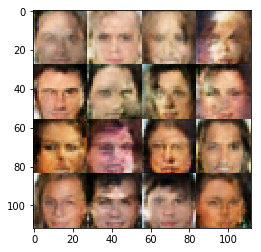

Epoch 1/1 Discriminator Loss: 1.2741... Generator Loss: 0.7608 3.5752 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1066... Generator Loss: 0.8461 2.8955 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0665... Generator Loss: 0.9790 2.8931 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2116... Generator Loss: 0.8877 2.8846 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9235... Generator Loss: 1.1232 2.8838 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3917... Generator Loss: 0.6715 2.8864 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1465... Generator Loss: 0.8720 2.8777 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2850... Generator Loss: 0.8716 2.8866 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1848... Generator Loss: 0.7827 2.8772 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0874... Generator Loss: 1.1124 2.8663 sec/every 10 batches


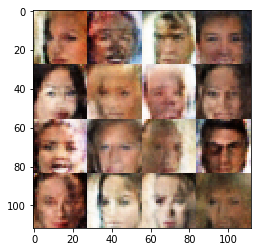

Epoch 1/1 Discriminator Loss: 1.0793... Generator Loss: 1.0983 3.4949 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2541... Generator Loss: 1.1576 2.8707 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1782... Generator Loss: 0.8725 2.8633 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4278... Generator Loss: 0.8692 2.8653 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3643... Generator Loss: 0.7454 2.8768 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3045... Generator Loss: 0.9208 2.8820 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0288... Generator Loss: 1.2662 2.8815 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2819... Generator Loss: 0.8476 2.8660 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4410... Generator Loss: 0.7863 2.8647 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1163... Generator Loss: 1.1579 2.8656 sec/every 10 batches


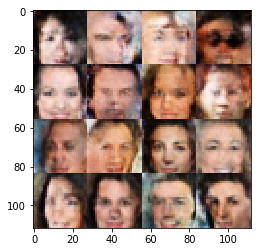

Epoch 1/1 Discriminator Loss: 1.3098... Generator Loss: 0.7596 3.4926 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9535... Generator Loss: 1.3524 2.8667 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3303... Generator Loss: 0.7898 2.9054 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2910... Generator Loss: 0.7361 2.9224 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2603... Generator Loss: 0.9688 2.9288 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3728... Generator Loss: 0.9073 2.8667 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1943... Generator Loss: 1.0707 2.8712 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1896... Generator Loss: 0.9021 2.8706 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1873... Generator Loss: 0.8864 2.8667 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0371... Generator Loss: 1.0586 2.8664 sec/every 10 batches


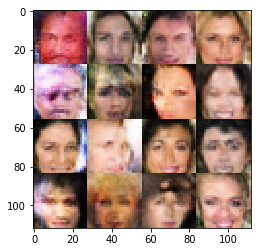

Epoch 1/1 Discriminator Loss: 0.9365... Generator Loss: 1.3796 3.5010 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3462... Generator Loss: 0.8498 2.8681 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3204... Generator Loss: 0.6801 2.8702 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0105... Generator Loss: 0.9649 2.8685 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1011... Generator Loss: 1.1422 2.8642 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1288... Generator Loss: 0.8870 2.8660 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0280... Generator Loss: 0.9657 2.8686 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1039... Generator Loss: 0.9534 2.8627 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2590... Generator Loss: 0.9758 2.8674 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3078... Generator Loss: 0.7078 2.8656 sec/every 10 batches


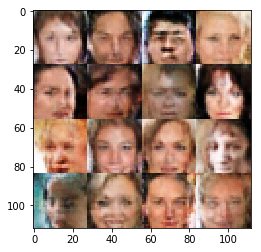

Epoch 1/1 Discriminator Loss: 1.1105... Generator Loss: 1.1030 3.5194 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2142... Generator Loss: 0.8177 2.8883 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0123... Generator Loss: 1.3434 2.8920 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.6333... Generator Loss: 0.4996 2.8822 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2696... Generator Loss: 0.9120 2.8848 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9381... Generator Loss: 1.0437 2.8738 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.5133... Generator Loss: 0.6486 2.8690 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1802... Generator Loss: 0.7241 2.8677 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1322... Generator Loss: 1.1212 2.8779 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2875... Generator Loss: 0.7154 2.8682 sec/every 10 batches


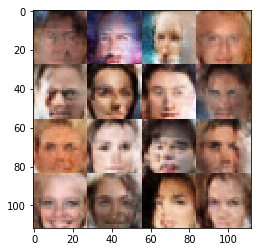

Epoch 1/1 Discriminator Loss: 1.0860... Generator Loss: 0.9949 3.5670 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1796... Generator Loss: 0.8720 2.8601 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0661... Generator Loss: 0.9361 2.8662 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2420... Generator Loss: 0.7598 2.8691 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1641... Generator Loss: 1.0574 2.8784 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2017... Generator Loss: 0.8887 2.9077 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1820... Generator Loss: 0.9704 2.9034 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0482... Generator Loss: 1.0463 2.8655 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4896... Generator Loss: 0.6593 2.8657 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2361... Generator Loss: 0.9173 2.8676 sec/every 10 batches


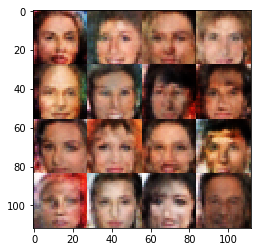

Epoch 1/1 Discriminator Loss: 1.0824... Generator Loss: 1.0728 3.5110 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3846... Generator Loss: 0.8255 2.8647 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3603... Generator Loss: 0.8903 2.8668 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2716... Generator Loss: 0.7869 2.8662 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1496... Generator Loss: 1.1060 2.8666 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1213... Generator Loss: 0.8936 2.8715 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1601... Generator Loss: 1.0656 2.8643 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0716... Generator Loss: 0.9837 2.8699 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1895... Generator Loss: 0.9681 2.8658 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1857... Generator Loss: 1.1309 2.8633 sec/every 10 batches


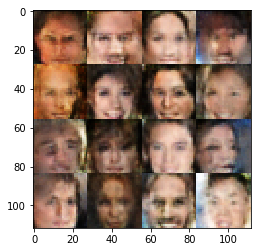

Epoch 1/1 Discriminator Loss: 1.2148... Generator Loss: 0.9153 3.5159 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3270... Generator Loss: 0.8674 2.8650 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2078... Generator Loss: 0.9893 2.8622 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1053... Generator Loss: 0.8810 2.8692 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8981... Generator Loss: 1.3107 2.8678 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2839... Generator Loss: 0.8673 2.8686 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4856... Generator Loss: 0.6402 2.8673 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1545... Generator Loss: 0.9565 2.8760 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0289... Generator Loss: 1.0386 2.8698 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3828... Generator Loss: 0.7796 2.8804 sec/every 10 batches


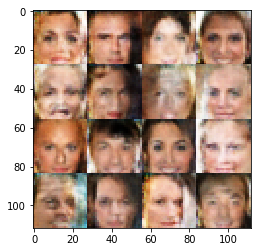

Epoch 1/1 Discriminator Loss: 1.2103... Generator Loss: 0.7491 3.5472 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0268... Generator Loss: 1.1030 2.8669 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0119... Generator Loss: 1.0280 2.8719 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.6338... Generator Loss: 0.6694 2.8782 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2142... Generator Loss: 0.8342 2.8710 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4292... Generator Loss: 0.5508 2.8671 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1649... Generator Loss: 0.7915 2.8761 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2681... Generator Loss: 0.6514 2.8637 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2031... Generator Loss: 0.8169 2.8816 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4011... Generator Loss: 0.5564 2.8835 sec/every 10 batches


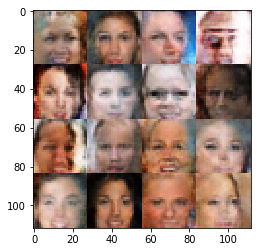

Epoch 1/1 Discriminator Loss: 1.2896... Generator Loss: 0.8793 3.5397 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1340... Generator Loss: 0.9918 2.8619 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3581... Generator Loss: 0.7444 2.8685 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1602... Generator Loss: 0.8746 2.8698 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1371... Generator Loss: 0.7530 2.8738 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1301... Generator Loss: 0.8416 2.8698 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9119... Generator Loss: 1.1172 2.8720 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7326... Generator Loss: 1.2822 2.8712 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2334... Generator Loss: 0.8688 2.8691 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4449... Generator Loss: 0.7733 2.8751 sec/every 10 batches


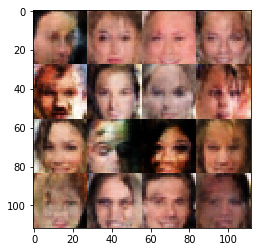

Epoch 1/1 Discriminator Loss: 1.0148... Generator Loss: 1.4007 3.5340 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3313... Generator Loss: 1.0484 2.8616 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0140... Generator Loss: 1.0497 2.8708 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1991... Generator Loss: 0.8338 2.8839 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2741... Generator Loss: 0.8206 2.8640 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9979... Generator Loss: 1.1406 2.8663 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2817... Generator Loss: 0.7940 2.8698 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4181... Generator Loss: 0.6211 2.8785 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1543... Generator Loss: 0.8363 2.8782 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1776... Generator Loss: 0.9873 2.8779 sec/every 10 batches


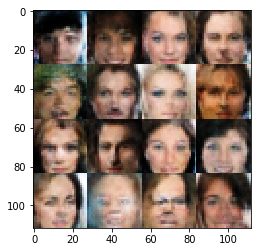

Epoch 1/1 Discriminator Loss: 1.0059... Generator Loss: 1.0898 3.5540 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2238... Generator Loss: 0.7211 2.8640 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2618... Generator Loss: 0.9035 2.8638 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2361... Generator Loss: 0.9122 2.8645 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1420... Generator Loss: 0.9649 2.8675 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7926... Generator Loss: 1.3837 2.8673 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.5385... Generator Loss: 0.5832 2.8791 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1992... Generator Loss: 0.8764 2.8746 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4775... Generator Loss: 0.6841 2.8760 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2746... Generator Loss: 0.8110 2.8652 sec/every 10 batches


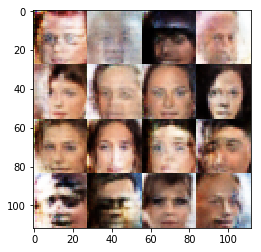

Epoch 1/1 Discriminator Loss: 1.5284... Generator Loss: 0.6207 3.9250 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3587... Generator Loss: 0.7611 2.8644 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2428... Generator Loss: 0.9861 2.8920 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2898... Generator Loss: 0.8895 2.8721 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1390... Generator Loss: 1.0312 2.8791 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2910... Generator Loss: 0.7722 2.8776 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3210... Generator Loss: 0.7358 2.8761 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2972... Generator Loss: 0.8070 2.8816 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1117... Generator Loss: 0.9182 2.8878 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1812... Generator Loss: 0.9341 2.8867 sec/every 10 batches


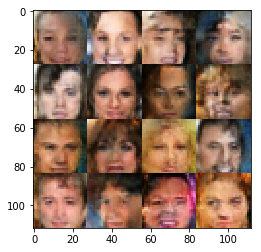

Epoch 1/1 Discriminator Loss: 1.3788... Generator Loss: 0.7973 3.6552 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3946... Generator Loss: 0.5628 2.8809 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2810... Generator Loss: 0.7197 2.8794 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7886... Generator Loss: 1.1912 2.8765 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3251... Generator Loss: 0.6306 2.8786 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3173... Generator Loss: 0.7892 2.8752 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2299... Generator Loss: 1.0402 2.8782 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1802... Generator Loss: 0.7420 2.8768 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3394... Generator Loss: 0.6338 2.8745 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2618... Generator Loss: 0.8654 2.8836 sec/every 10 batches


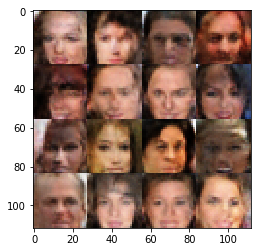

Epoch 1/1 Discriminator Loss: 1.5399... Generator Loss: 0.4449 3.5767 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3226... Generator Loss: 0.7757 2.8877 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3402... Generator Loss: 0.5853 2.8984 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2129... Generator Loss: 0.9897 2.8855 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1821... Generator Loss: 1.0523 2.8838 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3065... Generator Loss: 0.8169 2.8821 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3195... Generator Loss: 0.7532 2.8880 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0577... Generator Loss: 1.3395 2.9057 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0558... Generator Loss: 0.8470 2.8866 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4481... Generator Loss: 0.7135 2.8721 sec/every 10 batches


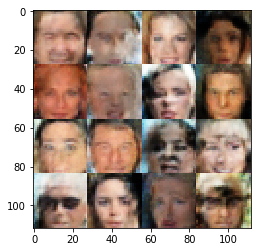

Epoch 1/1 Discriminator Loss: 1.1485... Generator Loss: 0.7728 3.5671 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1039... Generator Loss: 0.8318 2.8815 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1944... Generator Loss: 0.9180 2.8819 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1693... Generator Loss: 1.1663 2.8792 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2632... Generator Loss: 0.7584 2.8790 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3145... Generator Loss: 0.6940 2.8753 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3312... Generator Loss: 0.8930 2.8868 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1807... Generator Loss: 0.8853 2.8811 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3462... Generator Loss: 0.7293 2.8781 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1677... Generator Loss: 0.7448 2.8866 sec/every 10 batches


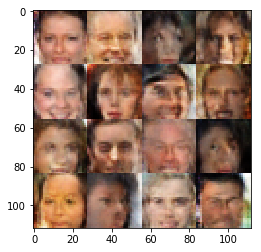

Epoch 1/1 Discriminator Loss: 1.3302... Generator Loss: 0.7951 3.6232 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1890... Generator Loss: 0.8568 2.8909 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4082... Generator Loss: 0.7392 2.8856 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0346... Generator Loss: 1.1885 2.8870 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3673... Generator Loss: 0.9128 2.8917 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1460... Generator Loss: 0.8136 2.8791 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2407... Generator Loss: 0.8636 2.8695 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1733... Generator Loss: 0.8634 2.8814 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2097... Generator Loss: 1.0518 2.8654 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1998... Generator Loss: 0.7679 2.8788 sec/every 10 batches


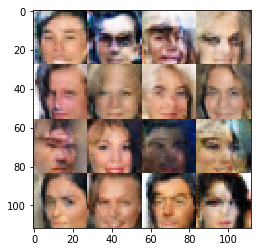

Epoch 1/1 Discriminator Loss: 0.9821... Generator Loss: 1.1693 3.5740 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2969... Generator Loss: 0.8996 2.8867 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0813... Generator Loss: 1.1182 2.8879 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7666... Generator Loss: 1.2743 2.8779 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9686... Generator Loss: 1.1900 2.8838 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3794... Generator Loss: 0.8020 2.8830 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3429... Generator Loss: 0.7182 2.8775 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1399... Generator Loss: 0.9718 2.8849 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3183... Generator Loss: 0.8446 2.8816 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2858... Generator Loss: 0.7925 2.8768 sec/every 10 batches


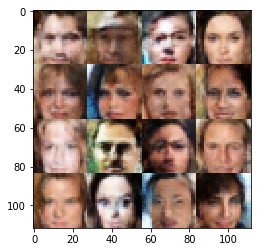

Epoch 1/1 Discriminator Loss: 1.2776... Generator Loss: 0.7616 3.6062 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2546... Generator Loss: 0.8213 2.8899 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0611... Generator Loss: 0.9978 2.8875 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.8618... Generator Loss: 0.4946 2.8713 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2909... Generator Loss: 0.8910 2.8664 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1095... Generator Loss: 0.8225 2.8720 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 2.0765... Generator Loss: 0.4103 2.8781 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3246... Generator Loss: 0.8653 2.8780 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2631... Generator Loss: 0.8676 2.8817 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0893... Generator Loss: 0.9323 2.8814 sec/every 10 batches


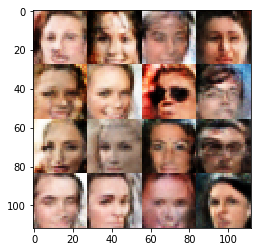

Epoch 1/1 Discriminator Loss: 1.3764... Generator Loss: 0.7346 3.6240 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1500... Generator Loss: 0.9850 2.8827 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.7927... Generator Loss: 1.4568 2.8663 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9530... Generator Loss: 1.1479 2.8665 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1915... Generator Loss: 0.9063 2.8647 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3184... Generator Loss: 0.7832 2.8594 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3115... Generator Loss: 0.8705 2.8669 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4034... Generator Loss: 0.7811 2.8695 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2635... Generator Loss: 0.8148 2.8784 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1397... Generator Loss: 0.9686 2.8816 sec/every 10 batches


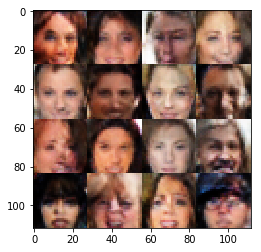

Epoch 1/1 Discriminator Loss: 1.2878... Generator Loss: 0.7606 3.5908 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0260... Generator Loss: 1.1259 2.8731 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3657... Generator Loss: 0.7496 2.8649 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1338... Generator Loss: 0.9109 2.8746 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0520... Generator Loss: 0.9875 2.8793 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4272... Generator Loss: 0.7089 2.8685 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1974... Generator Loss: 0.8661 2.8657 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.5032... Generator Loss: 0.6985 2.8718 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1407... Generator Loss: 0.8743 2.8670 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2235... Generator Loss: 0.9030 2.8751 sec/every 10 batches


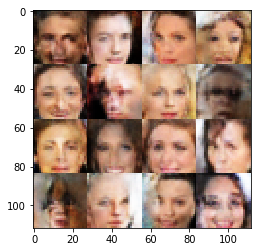

Epoch 1/1 Discriminator Loss: 1.3781... Generator Loss: 0.6725 3.6337 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3382... Generator Loss: 0.8831 2.8703 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2247... Generator Loss: 0.8106 2.8746 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4374... Generator Loss: 0.6165 2.8752 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.5991... Generator Loss: 0.6001 2.8845 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4366... Generator Loss: 0.6709 2.8705 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3491... Generator Loss: 0.6262 2.8654 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2997... Generator Loss: 0.8755 2.8718 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4962... Generator Loss: 0.6554 2.8782 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2724... Generator Loss: 0.7304 2.8779 sec/every 10 batches


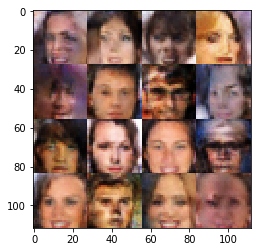

Epoch 1/1 Discriminator Loss: 1.1257... Generator Loss: 0.7958 3.6154 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4381... Generator Loss: 0.7492 2.8888 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0759... Generator Loss: 0.9236 2.8926 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1646... Generator Loss: 0.9597 2.8848 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2731... Generator Loss: 0.7655 2.8843 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3052... Generator Loss: 0.7812 2.8881 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2887... Generator Loss: 0.8271 2.8721 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3131... Generator Loss: 0.7799 2.8893 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3286... Generator Loss: 0.8978 2.8762 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3193... Generator Loss: 0.6950 2.8829 sec/every 10 batches


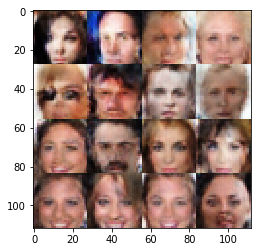

Epoch 1/1 Discriminator Loss: 1.1632... Generator Loss: 0.8587 3.6026 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1790... Generator Loss: 0.9041 2.8827 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0263... Generator Loss: 1.1106 2.8812 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9191... Generator Loss: 1.0642 2.8875 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2973... Generator Loss: 0.7543 2.8850 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2720... Generator Loss: 0.8531 2.8819 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3297... Generator Loss: 0.7912 2.8849 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0738... Generator Loss: 1.1483 2.8876 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0627... Generator Loss: 0.9736 2.8876 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.6569... Generator Loss: 0.5499 2.8853 sec/every 10 batches


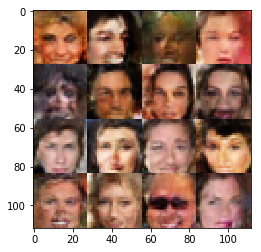

Epoch 1/1 Discriminator Loss: 0.9618... Generator Loss: 1.0323 3.7613 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3539... Generator Loss: 0.7570 2.8743 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3845... Generator Loss: 0.7089 2.8936 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4768... Generator Loss: 0.6640 2.9001 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1176... Generator Loss: 0.8098 2.9000 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.5888... Generator Loss: 0.5850 2.8798 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2002... Generator Loss: 0.6909 2.8917 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0980... Generator Loss: 0.9236 2.8919 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0828... Generator Loss: 1.1670 2.8967 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.6912... Generator Loss: 0.5826 2.8948 sec/every 10 batches


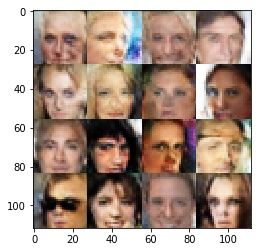

Epoch 1/1 Discriminator Loss: 1.2306... Generator Loss: 0.8909 3.6777 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2646... Generator Loss: 0.7427 2.9016 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0910... Generator Loss: 0.9684 2.8991 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4441... Generator Loss: 0.6896 2.8910 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1434... Generator Loss: 0.8876 2.8685 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2942... Generator Loss: 0.7766 2.8665 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3484... Generator Loss: 0.8752 2.8716 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8377... Generator Loss: 1.4624 2.8781 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4218... Generator Loss: 0.7499 2.8806 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3549... Generator Loss: 0.7312 2.8790 sec/every 10 batches


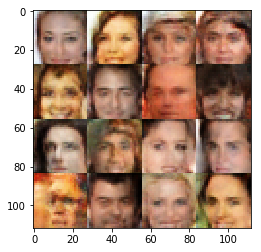

Epoch 1/1 Discriminator Loss: 1.1773... Generator Loss: 0.8361 3.6049 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3700... Generator Loss: 0.7585 2.8715 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3479... Generator Loss: 0.9352 2.8693 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1831... Generator Loss: 1.0737 2.8688 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3596... Generator Loss: 0.8769 2.8750 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8456... Generator Loss: 0.8137 2.8721 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.7177... Generator Loss: 0.4479 2.8657 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1937... Generator Loss: 0.9479 2.8792 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2125... Generator Loss: 0.7378 2.8816 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3039... Generator Loss: 0.7676 2.8825 sec/every 10 batches


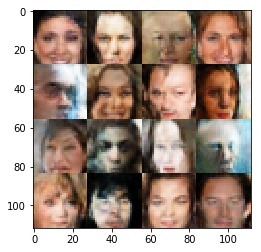

Epoch 1/1 Discriminator Loss: 1.2281... Generator Loss: 0.8614 3.6403 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2585... Generator Loss: 0.8459 2.8789 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1418... Generator Loss: 0.9557 2.8787 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1936... Generator Loss: 0.9736 2.8837 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3645... Generator Loss: 0.6249 2.8812 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2807... Generator Loss: 0.8748 2.8731 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2486... Generator Loss: 0.8167 2.8709 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2968... Generator Loss: 0.8183 2.8694 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2553... Generator Loss: 0.9201 2.8684 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4208... Generator Loss: 0.7898 2.8769 sec/every 10 batches


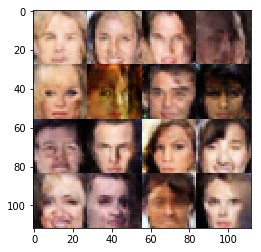

Epoch 1/1 Discriminator Loss: 1.3521... Generator Loss: 0.8802 3.6083 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0304... Generator Loss: 1.0817 2.8699 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3773... Generator Loss: 0.7095 2.9218 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0675... Generator Loss: 0.9470 2.9323 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3477... Generator Loss: 0.8074 2.8876 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3494... Generator Loss: 0.6189 2.8659 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1736... Generator Loss: 0.9353 2.8654 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4825... Generator Loss: 0.8177 2.8683 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1949... Generator Loss: 0.9341 2.8693 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.5214... Generator Loss: 0.6699 2.8800 sec/every 10 batches


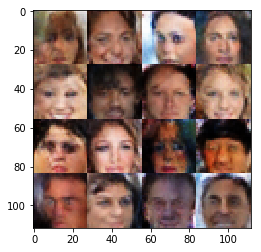

Epoch 1/1 Discriminator Loss: 1.1039... Generator Loss: 0.9495 3.6365 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4906... Generator Loss: 0.9178 2.8620 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2554... Generator Loss: 0.8750 2.8651 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9464... Generator Loss: 1.0770 2.8676 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1042... Generator Loss: 0.9848 2.8684 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.8722... Generator Loss: 1.0711 2.8656 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1895... Generator Loss: 0.9422 2.8667 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2047... Generator Loss: 1.0241 2.8641 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1135... Generator Loss: 0.9649 2.8730 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1985... Generator Loss: 0.9710 2.8700 sec/every 10 batches


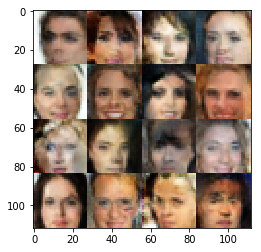

Epoch 1/1 Discriminator Loss: 1.4640... Generator Loss: 0.6394 4.0201 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9942... Generator Loss: 1.0434 2.8757 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.5383... Generator Loss: 0.7216 2.8896 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0432... Generator Loss: 1.1032 2.8653 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0116... Generator Loss: 0.9720 2.8717 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1992... Generator Loss: 0.8387 2.8687 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1825... Generator Loss: 0.6881 2.8710 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.4648... Generator Loss: 0.6207 2.8686 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1046... Generator Loss: 0.7253 2.8681 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0808... Generator Loss: 0.8893 2.8632 sec/every 10 batches


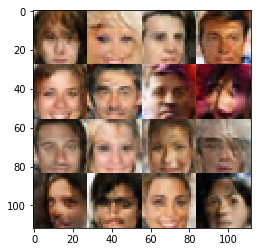

Epoch 1/1 Discriminator Loss: 1.2531... Generator Loss: 0.9517 3.6619 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.0615... Generator Loss: 1.2123 2.8767 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1278... Generator Loss: 0.8161 2.8666 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 0.9285... Generator Loss: 1.0639 2.8635 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.5701... Generator Loss: 0.6414 2.8618 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3377... Generator Loss: 0.8227 2.8724 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1388... Generator Loss: 0.8773 2.8744 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3209... Generator Loss: 0.8724 2.8708 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3673... Generator Loss: 0.7718 2.8743 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.3318... Generator Loss: 0.7968 2.8698 sec/every 10 batches


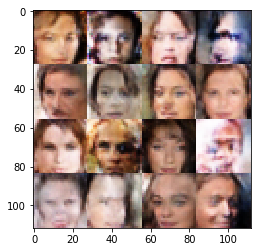

Epoch 1/1 Discriminator Loss: 1.2997... Generator Loss: 0.7391 3.7074 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.1661... Generator Loss: 0.9712 2.8683 sec/every 10 batches
Epoch 1/1 Discriminator Loss: 1.2136... Generator Loss: 0.9718 2.8689 sec/every 10 batches
Most recent model:


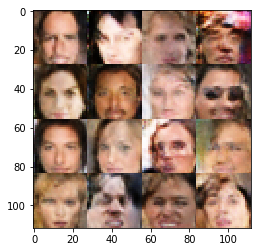

In [24]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.